In [1]:
import math
import numpy as np
import codecs, json 
import cv2
import matplotlib.pyplot as plt
from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata

In [2]:
c_error = np.array([[-0.91, -0.16, -0.23,  0.  , -0.09,  0.1 ,  0.31,  0.08],
       [-0.71, -0.19, -0.24, -0.05, -0.18, -0.02,  0.05, -0.09],
       [-0.66, -0.13, -0.36, -0.1 , -0.1 , -0.12, -0.03,  0.2 ],
       [-0.44, -0.28, -0.28, -0.11, -0.21, -0.13, -0.03, -0.21],
       [-0.3 , -0.09, -0.38, -0.27, -0.02, -0.29, -0.16, -0.11],
       [ 0.1 ,  0.28,  0.15,  0.2 ,  0.09,  0.17, -0.22,  0.21],
       [-0.28,  0.26,  0.42,  0.47,  0.62,  0.71,  0.66,  0.48],
       [-0.37,  0.06,  0.45,  0.6 ,  0.58,  0.39,  0.56,  0.36]])

In [3]:
c_maxnoise = np.array([[0.42, 0.18, 0.24, 0.26, 0.36, 0.42, 0.45, 0.44],
       [0.22, 0.21, 0.26, 0.31, 0.2 , 0.28, 0.22, 0.36],
       [0.18, 0.14, 0.12, 0.37, 0.12, 0.14, 0.29, 0.32],
       [0.2 , 0.3 , 0.29, 0.13, 0.23, 0.15, 0.3 , 0.23],
       [0.31, 0.1 , 0.14, 0.28, 0.29, 0.31, 0.18, 0.38],
       [0.42, 0.23, 0.37, 0.31, 0.18, 0.34, 0.24, 0.3 ],
       [0.29, 0.26, 0.34, 0.3 , 0.15, 0.3 , 0.35, 0.28],
       [0.39, 0.46, 0.32, 0.42, 0.43, 0.37, 0.46, 0.4 ]])

In [4]:
def read_tempdata(rn, path, is_deconv = True, raw =False):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
    if raw:
        arr = np.mean(arr,axis = 0)
    else:
#         arr = arr - c_error
        arr = np.amax(arr, axis = 0) - c_maxnoise
        if is_deconv:
            arr = np.linalg.solve(deconv,arr.reshape(-1)).reshape(8,8)
    return arr

def read_gtempdata(rn,gpath,num, is_deconv = True, raw = False):
    garr = np.zeros([num,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path,is_deconv,raw)
    return garr

In [5]:
deconv = np.zeros([8,8,8,8])
s = 0.50
for i in range(8):
    for j in range(8):
        weight = 0
        for m in range(8):
            for n in range(8):
                deconv[i,j,m,n] = math.exp(-math.pow(np.linalg.norm(np.array([i,j]-np.array([m,n])))/s,2)*0.5)
                weight += deconv[i,j,m,n]
        deconv[i,j] /= weight

deconv = np.reshape(deconv,(64,64))

In [6]:
MINTEMP = 26.
MAXTEMP = 32.

points = [(math.floor(ix / 8), (ix % 8)) for ix in range(0, 64)]
grid_x, grid_y = np.mgrid[0:7:64j, 0:7:64j]

def show_temp(arr):
    plt.figure(figsize=(6,5))
    bicubic = griddata(points, arr.reshape(-1), (grid_x, grid_y), method='cubic')
    pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = MINTEMP, vmax = MAXTEMP)
    plt.colorbar(pcm, fraction=0.175,pad=0.02)
    plt.axis('off')
    plt.show()
    
    return np.amax(bicubic)


def show_gtemp(garr,ln,weight = None):
    fig, axs = plt.subplots(ln, ln, figsize=(15, 15))
    amax = np.zeros((ln,ln))
    for n in range(ln**2):
        col = int(n/ln)
        row = int(n%ln)
        bicubic = griddata(points, garr[n].reshape(-1), (grid_x, grid_y), method='cubic')
        if np.any(weight) != None:
            wbicubic = griddata(points, weight[n].reshape(-1)*80, (grid_x, grid_y), method='cubic')/80
            wbicubic[wbicubic < 0] = 0
            wbicubic[wbicubic > 1] = 1
            bicubic = bicubic*(1-wbicubic) + np.amin(garr)*wbicubic
#             print(wbicubic[::8,::8].round(2))
#             bicubic *= (1-wbicubic)
        ax = axs[col,row]
        pcm = ax.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = MINTEMP, vmax = MAXTEMP)
        ax.set_axis_off()
        amax[col,row] = np.amax(bicubic)
#         print(np.amax(bicubic)-np.amin(bicubic))
    
    fig.colorbar(pcm, ax= axs[:], fraction=0.0175,pad=0.02)

    plt.show()
    print(amax.round(2))
    

In [7]:
def get_weight(garr,arrbg):
    diff = garr.reshape(-1,64)-arrbg.reshape(-1)
    
    weight = np.ones(diff.shape)
    for i in range(diff.shape[0]):
        n = 0
        n_skew = 10000
        bicubic = np.around(griddata(points, diff[i], (grid_x, grid_y), method='cubic').reshape(-1) * 4)/4.
        sort_diff = np.unique(bicubic)
        mode =  0
        start = 0
        for j in range(int(sort_diff.shape[0]/2)):
            num = bicubic[bicubic == sort_diff[j]].shape[0]
            if (num > mode):
                mode = num
                start = j
        for j in range(max(2,start),int(sort_diff.shape[0]/2)):
            t_skew = abs(st.skew(bicubic[bicubic < sort_diff[j]] ))
#             print(str(t_skew) + " " + str(bicubic[bicubic == sort_diff[j]].shape[0]) +" " + str(sort_diff[j]) + " " + str(j))
            if t_skew < n_skew:
                n_skew = t_skew
                n = sort_diff[j]
#         print("->" + str(n_skew))
#         print(" ")
        weight[i,diff[i] >= n] = 0 
    
    return weight.reshape(-1,8,8)

In [46]:
MINTEMP = 26.
MAXTEMP = 32.

ln = 6
datapath = 'train/warm/output-1/'
bgpath = 'train/warm/output-empty/1.txt'

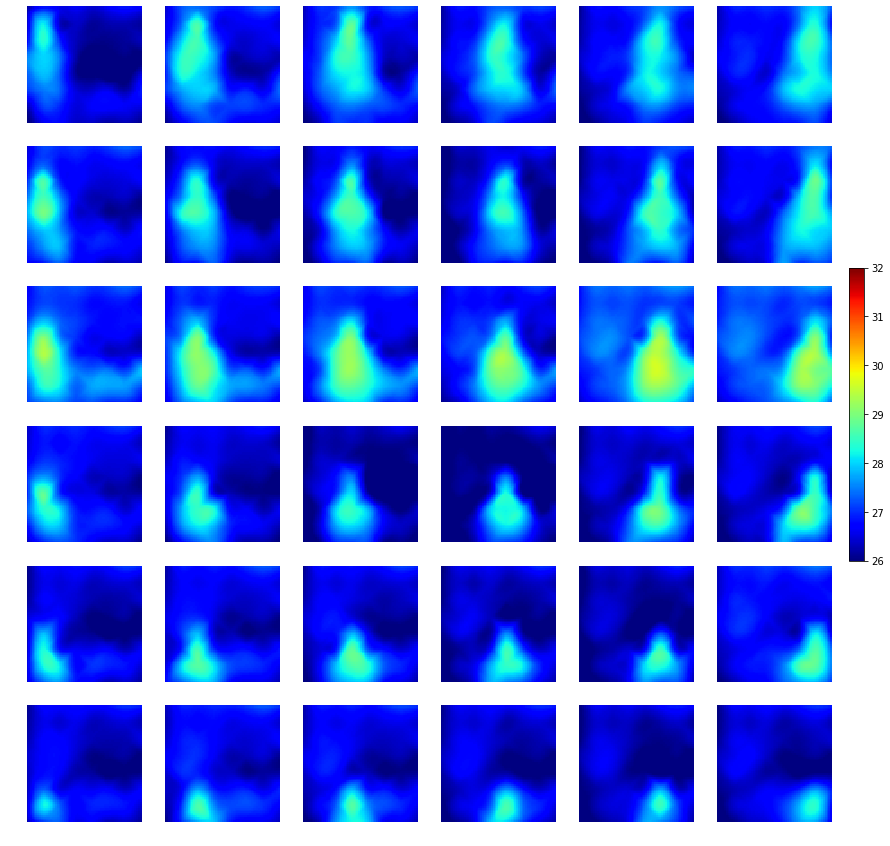

[[28.42 28.69 28.89 28.66 28.56 28.63]
 [28.96 28.68 28.73 28.58 28.77 28.89]
 [29.4  29.15 29.26 29.38 29.65 29.44]
 [28.86 28.62 28.51 28.43 29.02 29.11]
 [28.5  28.75 28.85 28.59 28.71 28.88]
 [28.23 28.69 28.7  28.64 28.54 28.43]]


In [47]:
garr = read_gtempdata(100,datapath,ln**2,raw = True)
show_gtemp(garr,ln)

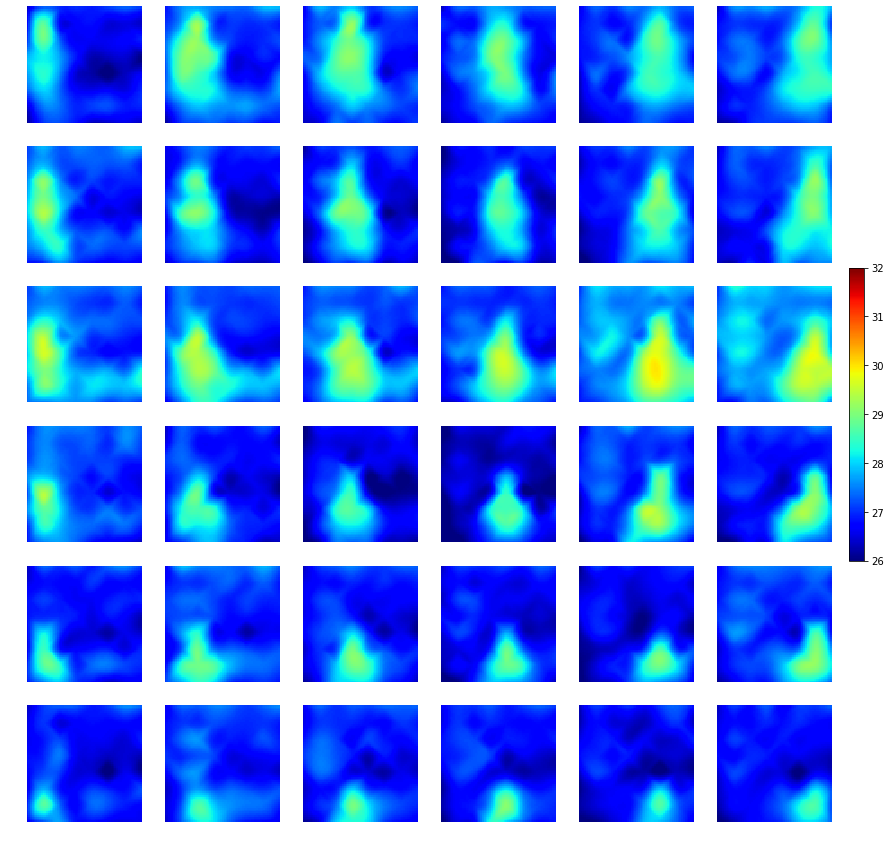

[[28.99 29.32 29.25 29.15 28.92 29.05]
 [29.4  29.13 29.14 28.82 29.23 29.21]
 [29.67 29.53 29.45 29.65 29.99 29.87]
 [29.47 28.94 28.76 28.82 29.56 29.37]
 [28.89 28.97 29.1  28.95 29.07 29.2 ]
 [28.76 28.73 28.97 29.1  28.71 28.68]]


In [48]:
garr = read_gtempdata(100,datapath,ln**2,is_deconv = False)
show_gtemp(garr,ln)

In [49]:
# garr = read_gtempdata(100,datapath,ln**2)
# show_gtemp(garr,ln)

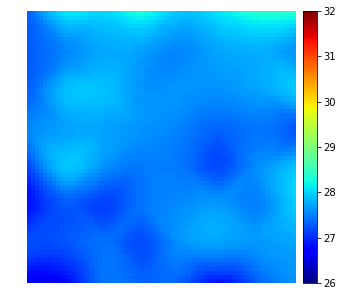

In [50]:
arrbg = read_tempdata(100,bgpath, is_deconv = False)
bicubic = show_temp(arrbg)

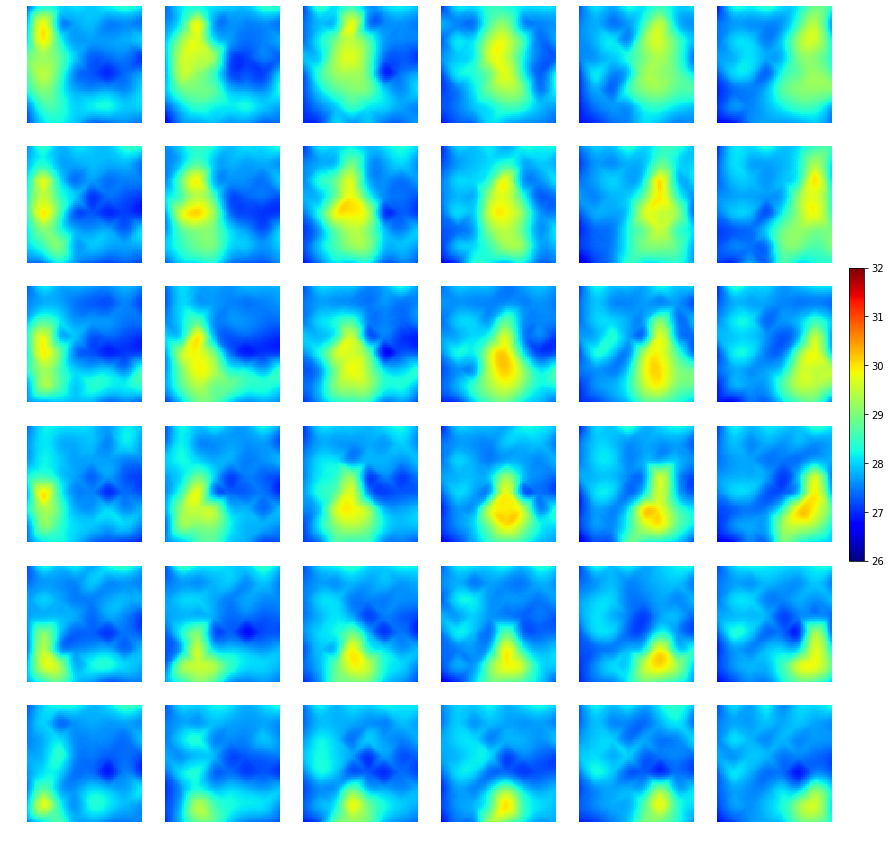

[[30.04 29.86 29.83 29.9  29.65 29.67]
 [29.95 30.1  30.12 29.95 30.09 29.98]
 [29.93 30.01 29.85 30.23 30.11 29.87]
 [30.05 29.83 29.95 30.19 30.23 30.21]
 [29.76 29.58 29.98 29.96 30.18 29.86]
 [29.7  29.42 29.79 30.02 29.8  29.62]]


In [51]:
weight = garr - arrbg
for i in range(ln**2):
    weight[i] = mixture.GaussianMixture(n_components=2).fit_predict(weight[i].reshape(-1,1)).reshape(-1,8,8)
    if weight[i].reshape(-1)[np.argmin(garr[i])] == 0:
        weight[i] = 1 -weight[i]

bg_mean = np.sum(garr*(weight),axis = (1,2))/np.sum(weight,axis = (1,2))
bg_max = np.max(bg_mean)

# garr2 = garr *(1-weight)  + ((weight).transpose(1,2,0)*bg_mean  + bg_max-bg_mean).transpose(2,0,1)
garr2 = (garr.transpose(1,2,0) + bg_max-bg_mean).transpose(2,0,1)

show_gtemp(garr2,ln)

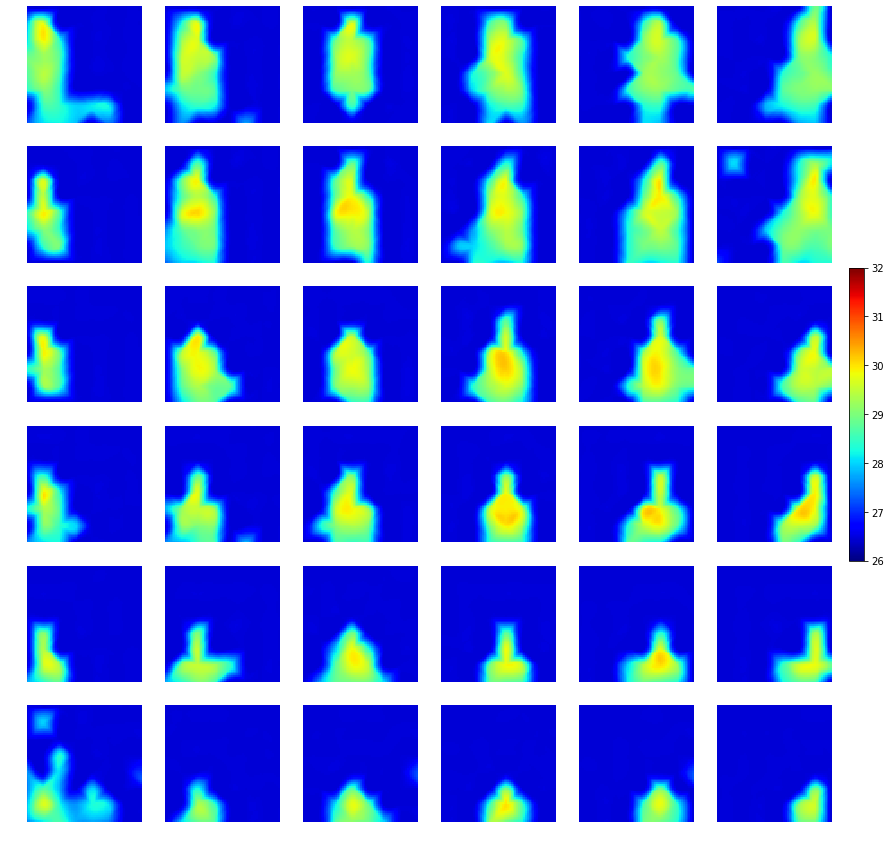

[[30.04 29.86 29.83 29.9  29.65 29.67]
 [29.95 30.1  30.12 29.95 30.07 29.98]
 [29.93 30.01 29.85 30.23 30.11 29.87]
 [30.05 29.83 29.95 30.19 30.23 30.21]
 [29.76 29.53 29.98 29.88 30.18 29.83]
 [29.7  29.42 29.79 30.02 29.8  29.62]]


In [52]:
show_gtemp(garr2,ln,weight)

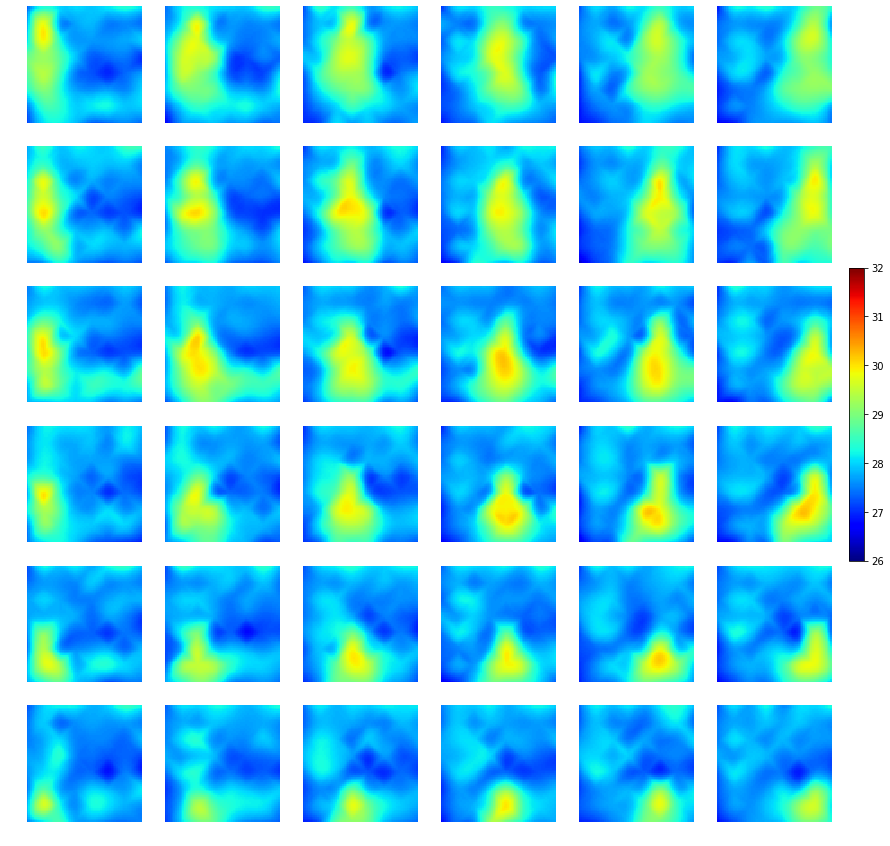

[[30.01 29.89 29.86 29.88 29.63 29.65]
 [30.06 30.08 30.11 29.93 30.07 29.95]
 [30.07 30.15 29.91 30.23 30.09 29.87]
 [30.05 29.86 29.94 30.17 30.23 30.26]
 [29.76 29.57 29.99 29.96 30.18 29.84]
 [29.66 29.46 29.78 30.   29.79 29.63]]


In [53]:
weight = get_weight(garr,arrbg)

bg_mean = np.sum(garr*(weight),axis = (1,2))/np.sum(weight,axis = (1,2))
bg_max = np.max(bg_mean)
bg_diff = (bg_max-bg_mean)

garr2 = (garr.transpose(1,2,0) + bg_diff).transpose(2,0,1)

show_gtemp(garr2,ln)

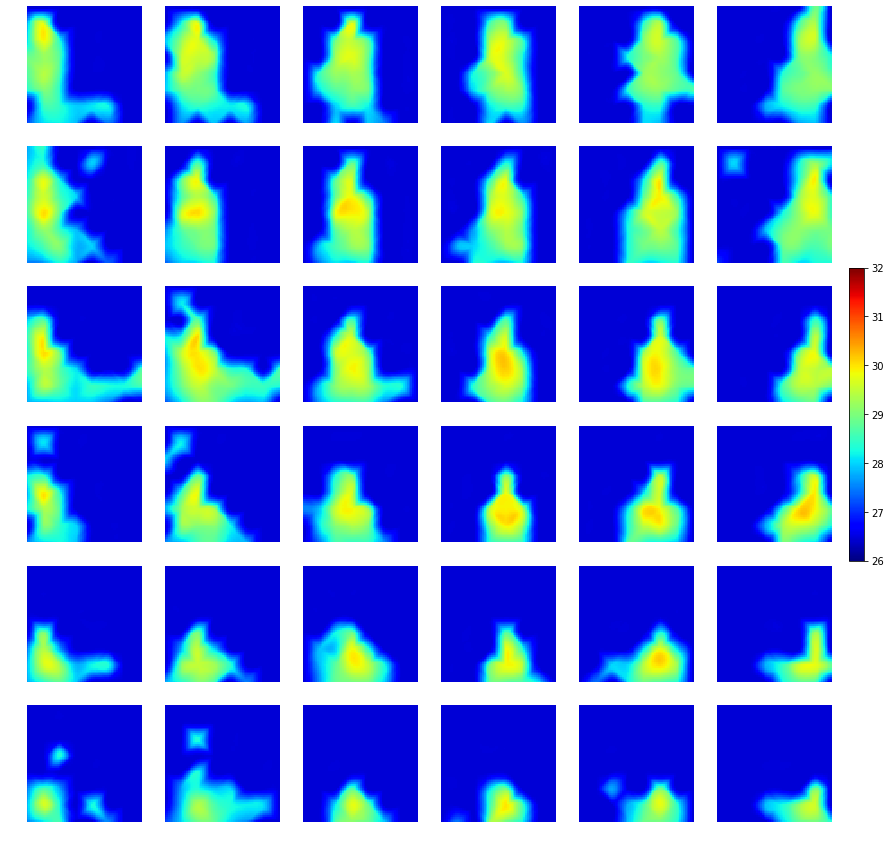

[[30.01 29.89 29.86 29.88 29.63 29.65]
 [30.06 30.08 30.11 29.93 30.05 29.95]
 [30.05 30.15 29.91 30.23 30.09 29.87]
 [30.03 29.86 29.93 30.17 30.14 30.26]
 [29.76 29.57 29.99 29.95 30.18 29.84]
 [29.66 29.4  29.78 30.   29.79 29.63]]


In [54]:
show_gtemp(garr2,ln,weight)

In [57]:
def thermal_interpolate(garr,ox,oy,nx,ny):
    interpol = np.zeros((nx,ny,8,8))
    for i in range(nx):
        for j in range(ny):
            y1 = math.floor(i*(oy-1)/ny)
            y2 = y1+1
            x1 = math.floor(j*(ox-1)/nx)
            x2 = x1+1
            ly = (i/ny - y1/oy)*oy
            lx = (j/nx - x1/ox)*ox
            inter1 = garr[y1*oy+x1]*(1-ly)+garr[y2*oy+x1]*ly
            inter2 = garr[y1*oy+x2]*(1-ly)+garr[y2*oy+x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol.reshape(-1,8,8)


interpol = thermal_interpolate(garr2,ln,ln,8,8)

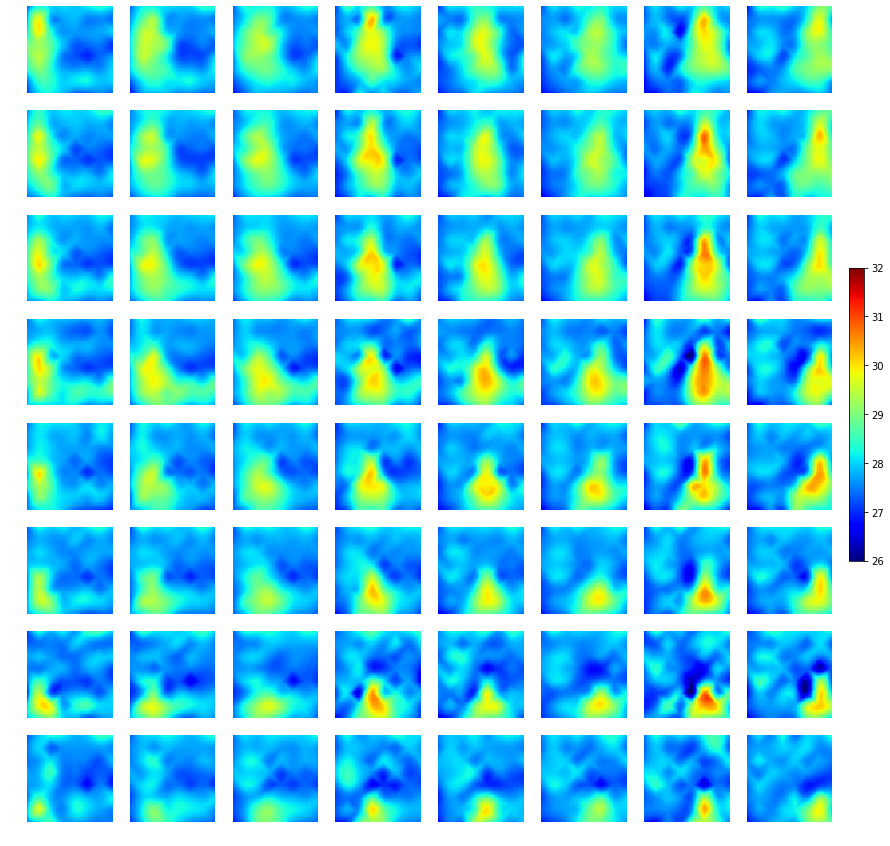

[[30.01 29.61 29.61 30.36 29.88 29.46 30.33 29.91]
 [29.9  29.8  29.82 30.21 29.86 29.64 30.89 30.29]
 [30.05 29.91 29.89 30.19 30.04 29.79 30.73 30.05]
 [30.13 29.91 29.97 30.12 30.37 30.18 30.88 30.16]
 [30.05 29.62 29.76 30.2  30.17 30.18 30.73 30.48]
 [29.61 29.43 29.51 30.24 29.98 29.99 30.6  30.1 ]
 [30.12 29.78 29.74 30.59 29.93 30.03 31.11 30.17]
 [29.66 29.1  29.18 30.08 30.05 29.42 30.38 29.88]]


In [58]:
show_gtemp(interpol,8)